In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import scipy
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
import requests 
from urllib.parse import urlencode 
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Остроухов Владислав.
3 Вариант.

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

    1. Был ли эксперимент успешен в целом.
    2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Исходные данные:
    
    Пользователи тестовой группы B (user_test)
    Транзации тестовой группы B (transaction_test)
    Пользователи контрольной группы А1 (user_control_1)
    Транзации контрольной группы А1 (transaction_control_1)
    Пользователи контрольной группы А2 (user_control_2)
    Транзации контрольной группы А2 (transaction_control_2)

In [2]:
# Функция для извлечения таблиц с яднекс диска.
def df (public_key):
    
    # Используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    #Получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
 
    #Загружаем файл в df 
    download_response = requests.get(download_url) 
    df = pd.read_csv(download_url, sep=';') 
    return df

In [3]:
# Функция bootstrap тестирования.
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [4]:
# Данные пользователей тестовой группы.
user_test = df('https://disk.yandex.ru/d/4XXIME4osGrMRA')
# Данные пользователей 1й контрольной группы группы.
user_control_1 = df('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
# Данные пользователей 2й контрольной группы группы.
user_control_2 = df('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
# Данные транзакций тестовой группы.
transaction_test = df('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
# Данные транзакций 1й контрольной группы группы.
transaction_control_1 = df('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
# Данные транзакций 2й контрольной группы группы.
transaction_control_2 = df('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

# Предобработка данных

Для начала нужно выполнить предобработку данных. Проверить на наличее дубликатов/пустых строк. Посмотреть на распределение внутри групп.

#### Проведем проверку для тестовой группы B.

In [5]:
user_test.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [6]:
user_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [7]:
user_test.shape

(4308, 13)

In [8]:
# Проверим наличие пустых значений.
user_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [9]:
# Проверим уникальность пользователей.
user_test.uid.nunique()

4308

In [10]:
# Количество уникальных пользователей соотсветвует общему количеству пользователей и строк в таблице.
# Проверку на дубликаты можно не проводить.

#### Проведем проверку для контрольной группы A1.

In [11]:
user_control_1.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [12]:
user_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [13]:
user_control_1.shape

(4340, 13)

In [14]:
# Проверим наличие пустых значений.
user_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [15]:
# Проверим уникальность пользователей.
user_control_1.uid.nunique()

4340

In [16]:
# Количество уникальных пользователей соотсветвует общему количеству пользователей и строк в таблице.
# Проверку на дубликаты можно не проводить.

#### Проведем проверку для контрольной группы A2.

In [17]:
user_control_2.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [18]:
user_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [19]:
user_control_2.shape

(4264, 13)

In [20]:
# Проверим наличие пустых значений.
user_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

In [21]:
# Проверим уникальность пользователей.
user_control_2.uid.nunique()

4264

In [22]:
# Количество уникальных пользователей соотсветвует общему количеству пользователей и строк в таблице.
# Проверку на дубликаты можно не проводить.

#### Проведем проверку для транзаций тестовой группы B.

In [23]:
transaction_test.sort_values('paid_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
184,891861594,Chile,2017-10-26 02:25:00,2017-01-11 04:37:00,4004,19,empty_likes,coins
245,891861048,Canada,2017-10-26 02:55:00,2017-01-11 07:13:00,3523,19,none,coins
260,892018248,United Kingdom (Great Britain),2017-10-22 19:50:00,2017-01-11 13:42:00,6032,19,likes,coins
183,891872313,Switzerland,2017-10-25 21:35:00,2017-01-11 23:36:00,9451,147,trial_vip_popup,trial_premium
74,892205850,Spain,2017-10-18 19:20:00,2017-02-11 00:13:00,5408,147,promo_09,premium_no_trial


In [24]:
transaction_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [25]:
# Колонки joined_at и paid_at имеют тип object. Сменим их тип на datetime64[ns].
transaction_test['joined_at'] = pd.to_datetime(transaction_test['joined_at'])
transaction_test['paid_at'] = pd.to_datetime(transaction_test['paid_at'])

In [26]:
transaction_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    int64         
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    int64         
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 17.2+ KB


In [27]:
# Проверим наличие пустых значений.
transaction_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [28]:
# Проверим число уникальных пользователей.
transaction_test.uid.nunique()

146

In [29]:
# Число уникальных пользователей не соответствует числу числу транзакций. 
# Стоит проверить, разные это были транзакции или в таблице присутствуют дубликаты.
transaction_test.uid.value_counts().head(5)

892236423    14
892065108     9
892339626     9
892057347     9
891174411     6
Name: uid, dtype: int64

In [30]:
# Более подробнее взглянем на транзакции пользователя.
transaction_test.query('uid == 892236423').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
125,892236423,United States of America,2017-10-18 01:09:00,2017-10-18 01:15:00,6292,147,left_sidebar_menu,premium_no_trial
238,892236423,United States of America,2017-10-18 01:09:00,2017-10-18 01:33:00,1261,19,empty_likes,coins
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
139,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,3783,67,empty_likes,other_type
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
214,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,6305,19,empty_likes,coins
112,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:09:00,12610,19,empty_likes,coins
81,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525,19,menu,coins
98,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,12610,19,menu,coins
167,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,3783,67,menu,other_type


In [31]:
# Наблюдаем дубликаты таких строк, как 17 и 188, 2 и 55.
# Проверим всю таблицу на наличие дубликатов.
transaction_test.duplicated().value_counts()

False    266
True       7
dtype: int64

In [32]:
# Всего в таблице обнаружено 7 дубликатов, стоит от них избавиться.
transaction_test_rd = transaction_test.drop_duplicates()

#### Проведем проверку для транзаций контрольной группы A1.

In [33]:
transaction_control_1.sort_values('paid_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium
124,892136748.0,France,2017-10-20 10:32:00,2017-01-11 04:10:00,2834.0,19.0,none,coins


In [34]:
transaction_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [35]:
# Колонки joined_at и paid_at имеют тип object. Сменим их тип на datetime64[ns].
transaction_control_1['joined_at'] = pd.to_datetime(transaction_control_1['joined_at'])
transaction_control_1['paid_at'] = pd.to_datetime(transaction_control_1['paid_at'])

In [36]:
transaction_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 63.1+ KB


In [37]:
# Проверим наличие пустых значений.
transaction_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [38]:
# Видим большое количество пустых значений.
transaction_control_1.tail(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1006,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [39]:
# Отчистим таблицу от пустых значений.
transaction_control_1 = transaction_control_1.dropna()

In [40]:
transaction_control_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    float64       
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    float64       
 5   payment_id    377 non-null    float64       
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 26.5+ KB


In [41]:
# Проверим число уникальных пользователей.
transaction_control_1.uid.nunique()

193

In [42]:
# Число уникальных пользователей не соответствует числу транзакций. 
# Стоит проверить, разные это были транзакции или в таблице присутствуют дубликаты.
transaction_control_1.uid.value_counts().head(5)

892333905.0    27
892069554.0    11
891707061.0    10
892366260.0    10
891367521.0    10
Name: uid, dtype: int64

In [43]:
# Более подробнее взглянем на транзакции пользователя.
transaction_control_1.query('uid == 892333905').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
49,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type
13,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
28,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type
296,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type
43,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
6,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins


In [44]:
# Наблюдаем большое количество дублированных строк.
# Проверим всю таблицу на наличие дубликатов.
transaction_control_1.duplicated().value_counts()

False    356
True      21
dtype: int64

In [45]:
# Всего в таблице обнаружен 21 дубликат, стоит от них избавиться.
transaction_control_1_rd = transaction_control_1.drop_duplicates()

#### Проведем проверку для транзаций контрольной группы A2.

In [46]:
transaction_control_2.sort_values('paid_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
129,891937068,Portugal,2017-10-24 14:22:00,2017-01-11 05:34:00,2015,19,none,coins
174,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,6279,147,left_sidebar_menu,premium_no_trial
49,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,2327,67,empty_mutual,other_type
20,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins
88,891877569,France,2017-10-25 19:32:00,2017-02-11 01:55:00,12675,147,trial_vip_popup,trial_premium


In [47]:
transaction_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [48]:
# Колонки joined_at и paid_at имеют тип object. Сменим их тип на datetime64[ns].
transaction_control_2['joined_at'] = pd.to_datetime(transaction_control_2['joined_at'])
transaction_control_2['paid_at'] = pd.to_datetime(transaction_control_2['paid_at'])

In [49]:
transaction_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    int64         
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    int64         
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 20.6+ KB


In [50]:
# Проверим наличие пустых значений.
transaction_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [51]:
# Проверим число уникальных пользователей.
transaction_control_2.uid.nunique()

187

In [52]:
# Число уникальных пользователей не соответствует числу числу транзакций.
# Стоит проверить, разные это были транзакции или в таблице присутствуют дубликаты.
transaction_control_2.uid.value_counts().head(10)

891637005    11
892230228    10
891080040     8
892139829     6
892435536     5
891722802     5
892128138     5
891862596     4
892318245     4
892045743     4
Name: uid, dtype: int64

In [53]:
# Более подробнее взглянем на транзакции пользователя.
transaction_control_2.query('uid == 891862596').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
170,891862596,Italy,2017-10-26 01:40:00,2017-10-29 14:14:00,6292,147,promo_09,premium_no_trial
6,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins
200,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:06:00,1261,19,autorefill,coins


In [54]:
# Наблюдаем дублированные строки, такие как 6 и 86.
# Проверим всю таблицу на наличие дубликатов.
transaction_control_2.duplicated().value_counts()

False    323
True       5
dtype: int64

In [55]:
# Всего в таблице обнаружено 5 дубликатов, стоит от них избавиться.
transaction_control_2_rd = transaction_control_2.drop_duplicates()

**Во время проверки данных было обнаружено, что время первой регистрации в группе A1 отличается от групп B и A2.**   

In [56]:
# Дата первой регистрации и последней регистрации в тестовой группе B.
print('Дата первой регистрации:', transaction_test_rd.joined_at.min())
print('Дата последней регистрации:',transaction_test_rd.joined_at.max())

Дата первой регистрации: 2017-01-11 03:07:00
Дата последней регистрации: 2017-10-31 23:40:00


In [57]:
# Дата первой и последней регистрации в контрольной группе A1.
print('Дата первой регистрации:', transaction_control_1_rd.joined_at.min())
print('Дата последней регистрации:',transaction_control_1_rd.joined_at.max())

Дата первой регистрации: 2015-01-19 11:49:00
Дата последней регистрации: 2017-10-31 22:17:00


In [58]:
# Дата первой и последней регистрации в контрольной группе A2.
print('Дата первой регистрации:', transaction_control_2_rd.joined_at.min())
print('Дата последней регистрации:',transaction_control_2_rd.joined_at.max())

Дата первой регистрации: 2017-01-11 08:36:00
Дата последней регистрации: 2017-10-31 17:43:00


In [59]:
# Посмотрим на данные группы A1
transaction_control_1_rd.sort_values('joined_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
342,891561825.0,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913.0,146.0,empty_likes,coins
368,891561825.0,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900.0,19.0,empty_likes,coins


Для чистоты экперемента думаю стоит очистить данные до 2017-01-11. Всего таких строк было обнаружено 3.

In [60]:
# Уберем данные до 2017-01-11.
transaction_control_1_rd = transaction_control_1_rd.query('joined_at >= "2017-01-11"')

In [61]:
transaction_control_1_rd.sort_values('joined_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
368,891561825.0,France,2017-01-11 01:06:00,2017-04-11 23:21:00,3900.0,19.0,empty_likes,coins
196,891561825.0,France,2017-01-11 01:06:00,2017-08-11 03:06:00,12636.0,147.0,trial_vip_popup,trial_premium
342,891561825.0,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913.0,146.0,empty_likes,coins
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial
167,891553362.0,United States of America,2017-01-11 08:26:00,2017-08-11 10:38:00,12727.0,147.0,autoreply_message,trial_premium


**Так же была обнаружена аномалия, что некоторые пользователи были зарегестрированы гораздо позже первой покупки.  
Рассмотрим эту аномалию подробнее.**

In [62]:
transaction_test.query('joined_at > paid_at').sort_values('paid_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
184,891861594,Chile,2017-10-26 02:25:00,2017-01-11 04:37:00,4004,19,empty_likes,coins
245,891861048,Canada,2017-10-26 02:55:00,2017-01-11 07:13:00,3523,19,none,coins
260,892018248,United Kingdom (Great Britain),2017-10-22 19:50:00,2017-01-11 13:42:00,6032,19,likes,coins
183,891872313,Switzerland,2017-10-25 21:35:00,2017-01-11 23:36:00,9451,147,trial_vip_popup,trial_premium
74,892205850,Spain,2017-10-18 19:20:00,2017-02-11 00:13:00,5408,147,promo_09,premium_no_trial


In [63]:
test_anomal = transaction_test.query('joined_at > paid_at').sort_values('paid_at')
pd.to_datetime(test_anomal['paid_at']).dt.day.value_counts()

11    47
Name: paid_at, dtype: int64

Среди всех значений paid_at наблюдается закономерность. Все даты заканчиваются на 11 число. Могу предположить, что в период с 01 по 10 ноября 2017 года наблюдалась ошибка в системе.

In [64]:
# Для начала посмотрим, есть ли значения в таблице за этот период.
transaction_test.query('"2017-11-01"<= paid_at <= "2017-11-10"').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [65]:
# Так же посмотрим, есть ли значения в таблице за оставшийся месяц.
transaction_test.query('"2017-11-11"<= paid_at <= "2017-11-30"').sort_values('paid_at').head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
104,892339626,United States of America,2017-10-15 23:21:00,2017-11-11 01:05:00,2587,68,none,premium_no_trial
141,892065108,France,2017-10-21 20:40:00,2017-11-11 03:28:00,12454,147,popular_users_chat,trial_premium
269,891447105,United Kingdom (Great Britain),2017-03-11 17:05:00,2017-11-11 04:23:00,7319,147,fans,premium_no_trial


In [66]:
transaction_test.query('"2017-11-11"<= paid_at <= "2017-11-30"').sort_values('paid_at').tail(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
239,891223299,United States of America,2017-07-11 08:52:00,2017-11-14 11:22:00,12727,147,trial_vip_popup,trial_premium
121,891605694,Argentina,2017-10-31 05:09:00,2017-11-15 04:33:00,12597,147,popular_users_block,premium_no_trial
195,891174411,Israel,2017-08-11 07:24:00,2017-11-15 09:31:00,14404,147,user_profile,trial_premium


Судя по всему предположение верно, но стоит проверить, наблюдается ли данная закономерность в других таблицах.

In [67]:
transaction_control_1.query('joined_at > paid_at').sort_values('paid_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium
124,892136748.0,France,2017-10-20 10:32:00,2017-01-11 04:10:00,2834.0,19.0,none,coins
254,891908385.0,Argentina,2017-10-25 02:33:00,2017-01-11 04:34:00,10686.0,147.0,trial_vip_popup,trial_premium
173,892207959.0,France,2017-10-18 18:30:00,2017-01-11 04:38:00,1261.0,19.0,empty_likes,coins
24,892207959.0,France,2017-10-18 18:30:00,2017-01-11 04:39:00,1261.0,19.0,empty_likes,coins


In [68]:
control_1_anomal = transaction_control_1.query('joined_at > paid_at').sort_values('paid_at')
pd.to_datetime(control_1_anomal['paid_at']).dt.day.value_counts()

11    55
Name: paid_at, dtype: int64

In [69]:
transaction_control_1.query('"2017-11-01"<= paid_at <= "2017-11-10"').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [70]:
transaction_control_1.query('"2017-11-11"<= paid_at <= "2017-11-30"').sort_values('paid_at').head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
86,891429846.0,Israel,2017-03-11 23:18:00,2017-11-11 01:19:00,14352.0,147.0,trial_vip_popup,trial_premium
320,891707061.0,Argentina,2017-10-29 10:54:00,2017-11-11 01:21:00,6305.0,19.0,empty_likes,coins
55,891707061.0,Argentina,2017-10-29 10:54:00,2017-11-11 01:30:00,1261.0,19.0,menu,coins


In [71]:
transaction_control_1.query('"2017-11-11"<= paid_at <= "2017-11-30"').sort_values('paid_at').tail(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
154,891707061.0,Argentina,2017-10-29 10:54:00,2017-11-15 03:41:00,1261.0,19.0,autorefill,coins
110,891174534.0,Argentina,2017-08-11 07:19:00,2017-11-15 09:19:00,10517.0,147.0,trial_vip_popup,trial_premium
229,891178713.0,United States of America,2017-08-11 03:39:00,2017-11-15 09:28:00,9087.0,147.0,trial_vip_popup,trial_premium


Как и ожидалось, данная закономерность наблюдается и в этой таблице. Проверим последнюю для достоверности.

In [72]:
transaction_control_2.query('joined_at > paid_at').sort_values('paid_at').head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
129,891937068,Portugal,2017-10-24 14:22:00,2017-01-11 05:34:00,2015,19,none,coins
174,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,6279,147,left_sidebar_menu,premium_no_trial
49,891664350,Germany,2017-10-30 00:21:00,2017-01-11 22:36:00,2327,67,empty_mutual,other_type
20,891609360,Italy,2017-10-31 02:07:00,2017-01-11 23:19:00,3913,146,empty_likes,coins
88,891877569,France,2017-10-25 19:32:00,2017-02-11 01:55:00,12675,147,trial_vip_popup,trial_premium


In [73]:
control_2_anomal = transaction_control_2.query('joined_at > paid_at').sort_values('paid_at')
pd.to_datetime(control_2_anomal['paid_at']).dt.day.value_counts()

11    60
Name: paid_at, dtype: int64

In [74]:
transaction_control_2.query('"2017-11-01"<= paid_at <= "2017-11-10"').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [75]:
transaction_control_2.query('"2017-11-11"<= paid_at <= "2017-11-30"').sort_values('paid_at').head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
294,891118668,Canada,2017-09-11 13:24:00,2017-11-11 03:11:00,897,146,empty_likes,coins
309,891118668,Canada,2017-09-11 13:24:00,2017-11-11 03:13:00,897,19,empty_likes,coins
302,891365604,United Kingdom (Great Britain),2017-05-11 03:50:00,2017-11-11 03:31:00,2158,67,empty_likes,other_type


In [76]:
transaction_control_2.query('"2017-11-11"<= paid_at <= "2017-11-30"').sort_values('paid_at').tail(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
326,891668253,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997,147,trial_vip_popup,trial_premium
171,892128138,Argentina,2017-10-20 14:49:00,2017-11-15 02:15:00,6305,19,autorefill,coins
10,892128138,Argentina,2017-10-20 14:49:00,2017-11-15 02:15:00,1261,19,menu,coins


**Во всех 3х таблицах наблюдается данная аномалия. Чистить таблицу от этих значений не будем, опираясь на предположение, что в период с 1 по 10 ноября 2017 года был сбой в системе, из-за чего день и месяц во время этого периода были поменяны местами.**

### Посмотрим на общую выручку пользователей и сравним ее между данными о пользователях и данными о транзакциях.

In [77]:
# Общая выручка в данных о тестовой группе B.
print('Данные о пользователях: Выручка', user_test.total_revenue.sum())
print('Данные о транзакциях: Выручка', transaction_test_rd.revenue.sum())

Данные о пользователях: Выручка 2300818
Данные о транзакциях: Выручка 2332226


In [78]:
# Общая выручка в  данных о контрольной группе А1.
print('Данные о пользователях: Выручка', user_control_1.total_revenue.sum())
print('Данные о транзакциях: Выручка', transaction_control_1_rd.revenue.sum())

Данные о пользователях: Выручка 2581267
Данные о транзакциях: Выручка 2493998.0


In [79]:
# Общая выручка в  данных о контрольной группе А2.
print('Данные о пользователях: Выручка', user_control_2.total_revenue.sum())
print('Данные о транзакциях: Выручка', transaction_control_2_rd.revenue.sum())

Данные о пользователях: Выручка 1920438
Данные о транзакциях: Выручка 1907997


**Выручка в таблицах различается, за основу для тестов будем брать выручку, указанную в данных о транзакциях.**

### Посмотрим на количество уникальных стран в данных о пользователях и в данных о транзакциях.

In [80]:
# Количесвто уникальных стран.
print('Данные о пользователях тестовой группы B: Уникальных стран', user_test.country.nunique())
print('Данные о транзакциях пользователей тестовой группы B: Уникальных стран', transaction_test_rd.country.nunique())
print('Данные о пользователях контрольной группе А1: Уникальных стран', user_control_1.country.nunique())
print('Данные о транзакциях пользователей контрольной группе А1: Уникальных стран', transaction_control_1_rd.country.nunique())
print('Данные о пользователях контрольной группе А2: Уникальных стран', user_control_2.country.nunique())
print('Данные о транзакциях пользователей контрольной группе А2: Уникальных стран', transaction_control_2_rd.country.nunique())

Данные о пользователях тестовой группы B: Уникальных стран 51
Данные о транзакциях пользователей тестовой группы B: Уникальных стран 17
Данные о пользователях контрольной группе А1: Уникальных стран 40
Данные о транзакциях пользователей контрольной группе А1: Уникальных стран 17
Данные о пользователях контрольной группе А2: Уникальных стран 45
Данные о транзакциях пользователей контрольной группе А2: Уникальных стран 19


**Количество уникальных стран в данных о пользователях сильно разнится. Стоит найти странны, которые присутсвуют во всех 3х таблицах о пользователях и на основе этих стран отфильтровать данные.**

In [81]:
# Для начала соберем в отдельный список странны, которые встречаются во всех 3х таблицах.
list1 = user_test['country']
list2 = user_control_1['country']
list3 = user_control_2['country']
country = reduce(np.intersect1d, (list1, list2, list3))

In [82]:
# Фильтруем данные по полученному списку.
user_test = user_test[user_test.country.isin(country)]
user_control_1 = user_control_1[user_control_1.country.isin(country)]
user_control_2 = user_control_2[user_control_2.country.isin(country)]
transaction_test_rd = transaction_test_rd[transaction_test_rd.country.isin(country)]
transaction_control_1_rd = transaction_control_1_rd[transaction_control_1_rd.country.isin(country)]
transaction_control_2_rd = transaction_control_2_rd[transaction_control_2_rd.country.isin(country)]

In [83]:
# Количесвто уникальных стран после фильтрации.
print('Данные о пользователях тестовой группы B: Уникальных стран', user_test.country.nunique())
print('Данные о транзакциях пользователей тестовой группы B: Уникальных стран', transaction_test_rd.country.nunique())
print('Данные о пользователях контрольной группе А1: Уникальных стран', user_control_1.country.nunique())
print('Данные о транзакциях пользователей контрольной группе А1: Уникальных стран', transaction_control_1_rd.country.nunique())
print('Данные о пользователях контрольной группе А2: Уникальных стран', user_control_2.country.nunique())
print('Данные о транзакциях пользователей контрольной группе А2: Уникальных стран', transaction_control_2_rd.country.nunique())

Данные о пользователях тестовой группы B: Уникальных стран 25
Данные о транзакциях пользователей тестовой группы B: Уникальных стран 16
Данные о пользователях контрольной группе А1: Уникальных стран 25
Данные о транзакциях пользователей контрольной группе А1: Уникальных стран 17
Данные о пользователях контрольной группе А2: Уникальных стран 25
Данные о транзакциях пользователей контрольной группе А2: Уникальных стран 17


### Посмотрим на распределение полов в данных о пользователях.

In [84]:
# Проверим распределение полов в тестовой группе B.
user_test.gender.value_counts().to_frame()

,gender
1,4071
0,200


In [85]:
# Проверим распределение полов в контрольной группе А1.
user_control_1.gender.value_counts().to_frame()

,gender
1,4137
0,182


In [86]:
# Проверим распределение полов в контрольной группе А2.
user_control_2.gender.value_counts().to_frame()

,gender
1,4044
0,194


**Распределение между полами в данных схоже. Заметно сильное преобладание одного пола, что, учитывая специфику дейтинового приложения, ожидаемо.**

### Посмотрим на распределение возрастов в данных о пользователях.

**Разобьем пользователей на группы, придерживаясь теории психосоциального развития Эрика Эриксона. 0-18 - детство, 19-35 молодость, 36-60 - взрослость, 60 и более - старость**

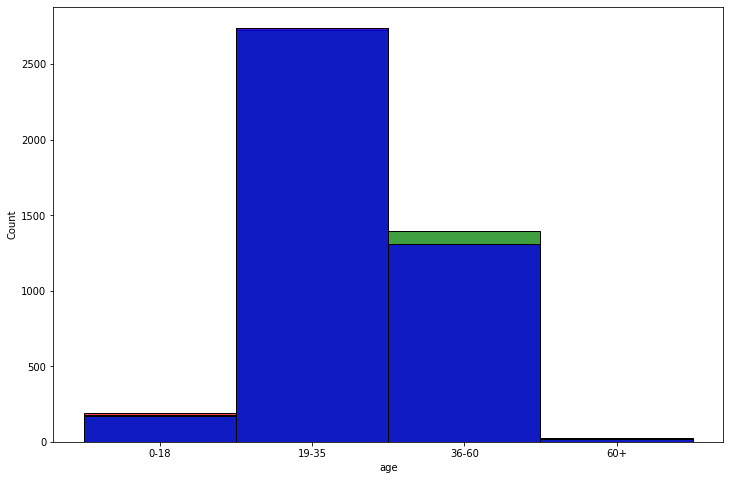

In [87]:
# Посмотрим на распределение возрастов во всех 3х группах.
plt.figure(figsize=(12, 8))
sns.histplot(pd.cut(user_test['age'], bins=[0, 18, 35, 60, 100], labels=['0-18', '19-35', '36-60', '60+']),  
             kde = False, color='Red')
sns.histplot(pd.cut(user_control_1['age'], bins=[0, 18, 35, 60, 100], labels=['0-18', '19-35', '36-60', '60+']),  
             kde = False, color='Green')
sns.histplot(pd.cut(user_control_2['age'], bins=[0, 18, 35, 60, 100], labels=['0-18', '19-35', '36-60', '60+']),  
             kde = False, color='Blue')

**Распределение возврастов в данных о группах схожи. Заметно преобладание пользоватей в возрасте от 19 до 36 лет.**

### Некоторая информация после чистки данных о транзакциях.

In [88]:
# Общее количество транзакций в группах и уникальных пользователей в группах.
print('В тестовой группе B:', 'транзакций -', transaction_test_rd.uid.count(), ',',  
      'уникальных пользователей - ', transaction_test_rd.uid.nunique())
print('В контрольной группе A1:', 'транзакций -', transaction_control_1_rd.uid.count(), ',',  
      'уникальных пользователей - ', transaction_control_1_rd.uid.nunique())
print('В контрольной группе A2:', 'транзакций -', transaction_control_2_rd.uid.count(), ',',  
      'уникальных пользователей - ', transaction_control_2_rd.uid.nunique())

В тестовой группе B: транзакций - 262 , уникальных пользователей -  145
В контрольной группе A1: транзакций - 353 , уникальных пользователей -  192
В контрольной группе A2: транзакций - 319 , уникальных пользователей -  185


# Итоги предобработки данных:



* Информация о пользователях в тестовой группе B, а так же в контрольных группах A1 и A2 содержится корректно. Дубликатов в данных обнаруженно не было, все пользователи в таблицах уникальны. Есть пустые значения в колонках coins, visit_days, was_premium и is_premium, что вполне ожидаемо и объяснимо, т.к. пользователь мог не покупать монеты, мог не заходить в приложение после его установки, а так же мог не покупать премиум статус.

    На первый взгляд данные схожи между собой по таким группам, как: 

    * Возраст (Заметно преобладание пользоватей в возрасте от 19 до 36 лет)
    * Распределение полов (хоть оно и смещено в сторону одного гендера, что ожидаемо для дейтингового приложения)
    
     Количество уникальных стран в данных о пользователях сильно разнится. В каждой из таблиц данных была произведена фильтрация по странам, которые есть во все таблицах с информацией о пользователях.
    

* Информация о транзакциях пользователей в тестовой группе была нарушена. Были обнаружены дубликаты (7), которые были очищены. Так же были сменены типы данных у колонок с датами. Cоотношение покупок к уникальным пользователям составило: 266 транзакций на 146 уникальных пользователей. Это говорит о том, что некоторые пользователи делали покупки более одного раза.


* Информация о транзакциях пользователей в контрольной группе A1 была нарушена. Было обнаружено большое количество пустых строк(630) и дубликатов(21). Так же было обнаружено, что дата первой регистрации пользователя не соответствует дате в группах B и A2, всего такой пользователь был 1. После проведения очистки дубликатов и пустых строк, а так же данных до 2017-01-11, соотношение транзакций к уникальным пользователям составило 353 к 192, что сразу бросается в глаза, если сравнивать значения с тестовой группой B.


* Информация о транзакциях пользователей в контрольной группе A2 имеет те же проблемы, что и информация о транзакциях пользователей в тестовой группе. Колонки были сменены, дубликаты(5) были очищены. Соотношение покупок к уникальным пользователям состовляет 323 к 187, что немного меньше, нежели в контрольной группе A1.


* Так же во всех 3х таблицах о транзакциях пользователей была обнаружена аномалия, связанная с тем, что ряд пользователей был зарегистрирован после 1й покупки. Основываясь на предположении, что в период с 01 по 10 ноября 2017 года наблюдалась ошибка в системе, из-за чего день и месяц были поменяны местами, данные были оставленны.

#  Проверка требований дизайна эксперимента.

Для проверки корректности проведения A/A/B теста для начала нужно проверить систему сплитования, на основе которой были отобраны группы A1 и A2. Проверять систему будем по CR, ARPU и ARPPU, т.к. интересуют именно эти метрики. Если между группами стат.значимых различие наблюдаться не будет - можно будет переходить к A/A/B тестированию.

Перед проведением теста объеденим таблицы с информацией о пользователях с таблицами о транзакциях пользователей с учётом того, что выручка в таблицах разная.

In [89]:
# Для начала преобразуем таблицы транзакций.
transaction_test_rd2 = transaction_test_rd.groupby(['uid'], as_index=False).agg({'revenue': 'sum'})
transaction_control_1_rd2 = transaction_control_1_rd.groupby(['uid'], as_index=False).agg({'revenue': 'sum'})
transaction_control_2_rd2 = transaction_control_2_rd.groupby(['uid'], as_index=False).agg({'revenue': 'sum'})

In [90]:
# Удалим колонку с выручкой из информации о пользователях.
user_test_rd = user_test.drop(columns = {'total_revenue'})
user_control_1_rd = user_control_1.drop(columns = {'total_revenue'})
user_control_2_rd = user_control_2.drop(columns = {'total_revenue'})

In [91]:
# Объеденим таблицы.
user_test_new = user_test_rd.merge(transaction_test_rd2, how='left', on='uid')
user_control_1_new = user_control_1_rd.merge(transaction_control_1_rd2, how='left', on='uid')
user_control_2_new = user_control_2_rd.merge(transaction_control_2_rd2, how='left', on='uid')

In [92]:
# Проверим, изменилось ли количество строк в таблицах.
print('Количество строк и столбцов в данных о тестовой группе B до объеденения:',
      user_test.shape, 'После объеденения:', user_test_new.shape)
print('Количество строк и столбцов в данных о контрольной группе A1 до объеденения:',
      user_control_1.shape, 'После объеденения:', user_control_1_new.shape)
print('Количество строк и столбцов в данных о контрольной группе A2 до объеденения:',
      user_control_2.shape, 'После объеденения:', user_control_2_new.shape)

Количество строк и столбцов в данных о тестовой группе B до объеденения: (4271, 13) После объеденения: (4271, 13)
Количество строк и столбцов в данных о контрольной группе A1 до объеденения: (4319, 13) После объеденения: (4319, 13)
Количество строк и столбцов в данных о контрольной группе A2 до объеденения: (4238, 13) После объеденения: (4238, 13)


In [93]:
# Заменим все значение NaN на 0.
user_test_new = user_test_new.fillna(0)
user_control_1_new = user_control_1_new.fillna(0)
user_control_2_new = user_control_2_new.fillna(0)

In [94]:
# Сделаем таблицы для проверки CR.

In [95]:
trans_cr_test = transaction_test_rd.query('product_type == "premium_no_trial"').drop_duplicates('uid')
cr_test = user_test_rd.merge(trans_cr_test, on='uid', how='left').fillna(0)
cr_test['premium_no_trial'] = cr_test.product_type.str.contains('premium_no_trial').fillna(0)
cr_test['group'] = 'test'

In [96]:
trans_cr_control_1 = transaction_control_1_rd.query('product_type == "premium_no_trial"').drop_duplicates('uid')
cr_control_1 = user_control_1_rd.merge(trans_cr_control_1, on='uid', how='left').fillna(0)
cr_control_1['premium_no_trial'] = cr_control_1.product_type.str.contains('premium_no_trial').fillna(0)
cr_control_1['group'] = 'control_1'

In [97]:
trans_cr_control_2 = transaction_control_2_rd.query('product_type == "premium_no_trial"').drop_duplicates('uid')
cr_control_2 = user_control_2_rd.merge(trans_cr_control_2, on='uid', how='left').fillna(0)
cr_control_2['premium_no_trial'] = cr_control_2.product_type.str.contains('premium_no_trial').fillna(0)
cr_control_2['group'] = 'control_2'

In [98]:
cr_control_2

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type,premium_no_trial,group
0,892035504,37,137,0.0,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
1,891782112,57,0,0.0,Italy,1,1,54,60,0,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
2,891110337,30,769,0.0,France,"1,2,3,4,5",1,27,33,13,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
3,891796320,48,750,0.0,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
4,891880212,54,638,0.0,United States of America,1,1,35,53,94,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,891937401,63,242,0.0,Italy,"1,2",1,50,66,33,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
4234,891692844,35,500,0.0,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
4235,891096429,41,333,0.0,United States of America,0,1,38,44,6,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2
4236,891697584,48,210,0.0,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,...,0.0,0,0,0,0.0,0.0,0,0,0,control_2


Проверим ARPPU пользователей на предмет выбросов.

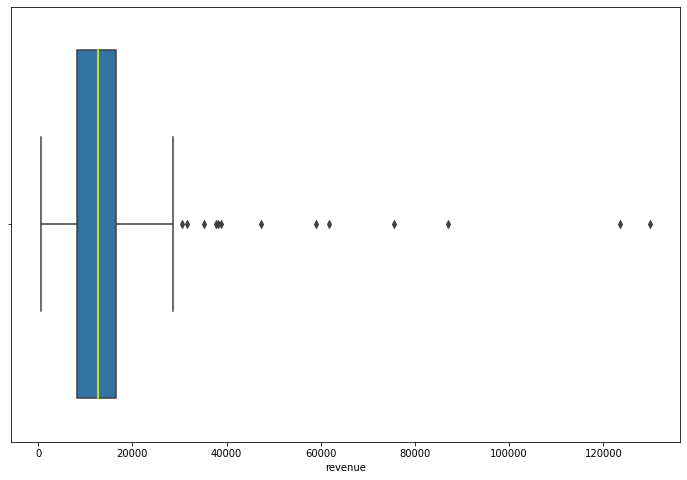

In [99]:
# ARPPU пользователей в тестовой группе B.
plt.figure(figsize=(12, 8))
sns.boxplot(x = user_test_new.query('revenue > 0').revenue, medianprops={"color": "yellow"})

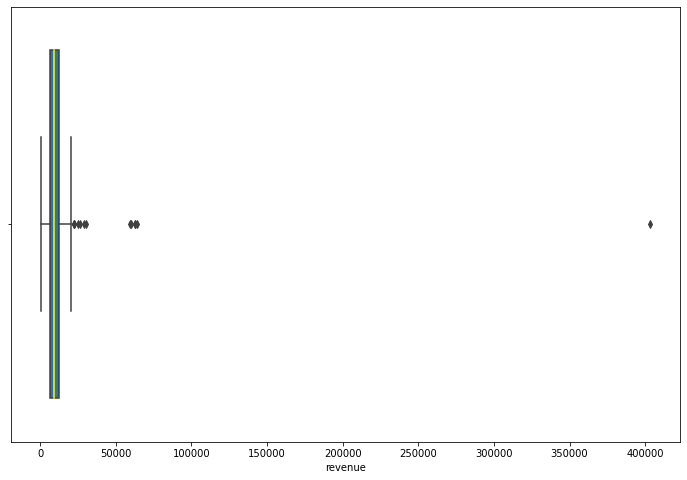

In [100]:
# ARPPU пользователей в контрольной группе A1.
plt.figure(figsize=(12, 8))
sns.boxplot(x = user_control_1_new.query('revenue > 0').revenue, medianprops={"color": "yellow"})

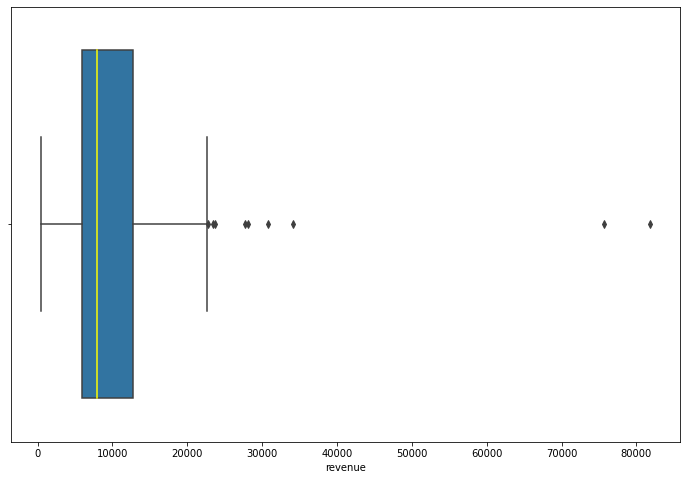

In [101]:
# ARPPU пользователей в контрольной группе A2.
plt.figure(figsize=(12, 8))
sns.boxplot(x = user_control_2_new.query('revenue > 0').revenue, medianprops={"color": "yellow"})

**Среди данных присутсвуют выбросы. Самый сильный выброс замечен в 1й контрольной группе. Рассмотрим эту группу по подробнее.**

In [102]:
transaction_control_1_rd2.sort_values('revenue')

,uid,revenue
81,891653790.0,728.0
78,891622389.0,767.0
4,891135642.0,962.0
100,891792453.0,1313.0
155,892176342.0,1508.0
...,...,...
189,892421277.0,60333.0
184,892366260.0,63024.0
49,891383310.0,63037.0
163,892216461.0,64298.0


Видим, что у одного пользователя очень большое количество выручки. Проведем анализ, какие именно типы транзакций делал этот пользователь.

In [103]:
transaction_control_1_rd.groupby(['uid', 'product_type', 'country'], as_index=False).agg({'revenue': 'sum'}).query('uid == 892333905')

,uid,product_type,country,revenue
241,892333905.0,coins,Italy,317369.0
242,892333905.0,other_type,Italy,22698.0
243,892333905.0,premium_no_trial,Italy,63037.0


Как можно заметить, этот пользователь делал в разы больше покупок по сравнению с остальными платящими пользователями. Если оставить информацию об этом пользователе в дальнейших тестах - итоге теста будут сильно искажены.

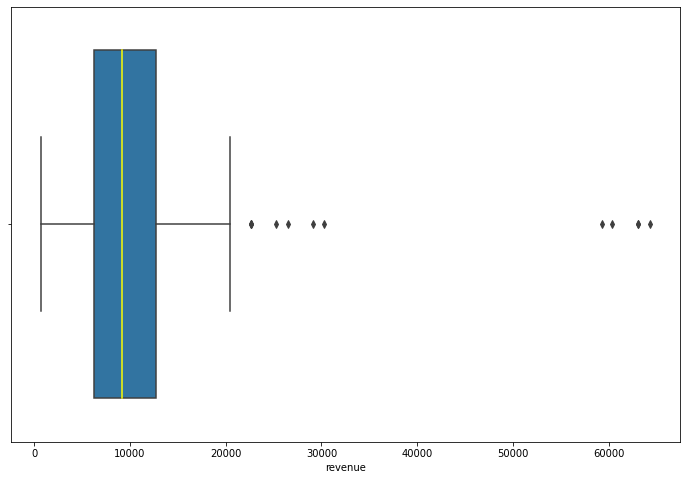

In [104]:
# ARPPU пользователей в контрольной группе A1 при исключении пользователя с UID 892333905.
plt.figure(figsize=(12, 8))
sns.boxplot(x = user_control_1_new.query('revenue > 0 & uid != 892333905').revenue, medianprops={"color": "yellow"})

### Сравнение распределения по полу между группами B/A1/A2

In [105]:
n_s = 100
simulations = 100

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_control_1[{'gender', 'group'}].sample(n=n_s)
    s2 = cr_control_2[{'gender', 'group'}].sample(n=n_s)
    s3 = pd.concat([s1, s2])
    cross = pd.crosstab(s3.group, s3.gender)
    if cross.shape[1] == 1: #в случае, если премиумов нет ни одного, заполняем нулями, иначе scipy выдаст ошибку
        cross['True'] = 0
    res.append(scipy.stats.fisher_exact(cross)[1]) # сохраняем pvalue
    
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations)


0.04


In [106]:
n_s = 100
simulations = 100

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_test[{'gender', 'group'}].sample(n=n_s)
    s2 = cr_control_1[{'gender', 'group'}].sample(n=n_s)
    s3 = pd.concat([s1, s2])
    cross = pd.crosstab(s3.group, s3.gender)
    if cross.shape[1] == 1: #в случае, если премиумов нет ни одного, заполняем нулями, иначе scipy выдаст ошибку
        cross['True'] = 0
    res.append(scipy.stats.fisher_exact(cross)[1]) # сохраняем pvalue
    
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations)


0.01


In [107]:
n_s = 100
simulations = 100

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_test[{'gender', 'group'}].sample(n=n_s)
    s2 = cr_control_2[{'gender', 'group'}].sample(n=n_s)
    s3 = pd.concat([s1, s2])
    cross = pd.crosstab(s3.group, s3.gender)
    if cross.shape[1] == 1: #в случае, если премиумов нет ни одного, заполняем нулями, иначе scipy выдаст ошибку
        cross['True'] = 0
    res.append(scipy.stats.fisher_exact(cross)[1]) # сохраняем pvalue
    
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations)


0.01


**По скольку FPR < alpha(0.05), стат.значимых различий между группами не обранужено.**

### Сравнение распределения по возрастам между группами B/A1/A2

In [108]:
cr_test['age_group'] = pd.cut(user_test_new['age'], bins=[0, 18, 35, 60, 100],  
                                    labels=['0-18', '19-35', '36-60', '60+'])
cr_control_1['age_group'] = pd.cut(user_control_1_new['age'], bins=[0, 18, 35, 60, 100],  
                                         labels=['0-18', '19-35', '36-60', '60+'])
cr_control_2['age_group'] = pd.cut(user_control_2_new['age'], bins=[0, 18, 35, 60, 100],  
                                         labels=['0-18', '19-35', '36-60', '60+'])
user_test_new['age_group'] = pd.cut(user_test_new['age'], bins=[0, 18, 35, 60, 100],  
                                    labels=['0-18', '19-35', '36-60', '60+'])
user_control_1_new['age_group'] = pd.cut(user_test_new['age'], bins=[0, 18, 35, 60, 100],  
                                    labels=['0-18', '19-35', '36-60', '60+'])
user_control_2_new['age_group'] = pd.cut(user_test_new['age'], bins=[0, 18, 35, 60, 100],  
                                    labels=['0-18', '19-35', '36-60', '60+'])

In [109]:
print("Сравнение А1/A2:",scipy.stats.ttest_rel(cr_control_1.groupby('age_group').agg({'uid': 'count'}),  
                                              cr_control_2.groupby('age_group').agg({'uid': 'count'})))
print("Сравнение B/A1:",scipy.stats.ttest_rel(cr_test.groupby('age_group').agg({'uid': 'count'}),  
                                              cr_control_1.groupby('age_group').agg({'uid': 'count'})))
print("Сравнение B/A2:",scipy.stats.ttest_rel(cr_test.groupby('age_group').agg({'uid': 'count'}),  
                                              cr_control_2.groupby('age_group').agg({'uid': 'count'})))


Сравнение А1/A2: Ttest_relResult(statistic=array([0.96843497]), pvalue=array([0.4042613]))
Сравнение B/A1: Ttest_relResult(statistic=array([-0.49863122]), pvalue=array([0.65230568]))
Сравнение B/A2: Ttest_relResult(statistic=array([1.48825914]), pvalue=array([0.23342106]))


**Во всех 3х случаях Pvalue > 0.05, стат.значимых различий между группами не обранужено.**

### Сравнение распределения по странам между группами B/A1/A2

In [110]:
print("Сравнение А1/A2:",scipy.stats.ttest_rel(cr_control_1.groupby('country_x').agg({'uid': 'count'}),  
                                              cr_control_2.groupby('country_x').agg({'uid': 'count'})))
print("Сравнение B/A1:",scipy.stats.ttest_rel(cr_test.groupby('country_x').agg({'uid': 'count'}),  
                                              cr_control_1.groupby('country_x').agg({'uid': 'count'})))
print("Сравнение B/A2:",scipy.stats.ttest_rel(cr_test.groupby('country_x').agg({'uid': 'count'}),  
                                              cr_control_2.groupby('country_x').agg({'uid': 'count'})))

Сравнение А1/A2: Ttest_relResult(statistic=array([1.14664107]), pvalue=array([0.26283367]))
Сравнение B/A1: Ttest_relResult(statistic=array([-0.69328387]), pvalue=array([0.49478672]))
Сравнение B/A2: Ttest_relResult(statistic=array([0.47958058]), pvalue=array([0.63586713]))


**Во всех 3х случаях Pvalue > 0.05, стат.значимых различий между группами не обранужено.**

### Сравнение распределения по коэффициенту привлекательности между группами B/A1/A2

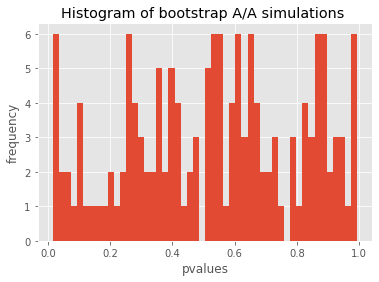

0.04


In [160]:
n_s = 150
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_control_1.attraction_coeff.sample(n_s, replace = False)
    s2 = cr_control_2.attraction_coeff.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

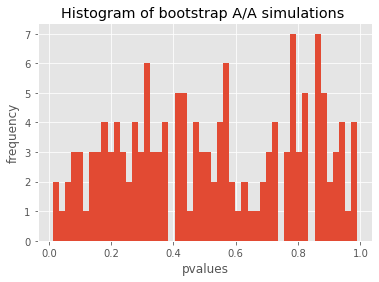

0.02


In [163]:
n_s = 150
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_control_1.attraction_coeff.sample(n_s, replace = False)
    s2 = cr_test.attraction_coeff.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

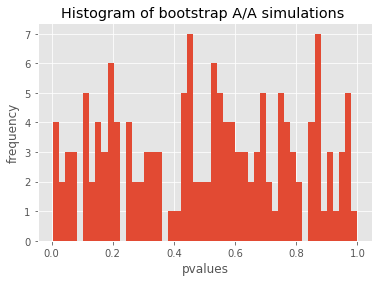

0.04666666666666667


In [165]:
n_s = 150
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_test.attraction_coeff.sample(n_s, replace = False)
    s2 = cr_control_2.attraction_coeff.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

**По скольку во всех 3х тестах FPR < alpha(0.05), можно сделать вывод, что средние в группах стат.значимо не различаются.**

#  Итог проверки требований дизайна эксперимента.

**Стат.значимых различий в  группах по таким признаками, как:**  
  
   **1. Распределение по возрастным группам,**  
   **2. Распределение по странам,**  
   **3. Распределение по полу,**  
   **4. Распределение по коэффициенту привлекательность,**  
     
**обнаружено не было. Можно переходить к A/A тестированию.**

#  А/А тест.

### Для проведения теста CR и распределения полов будет использован точный тест Фишера, для проведения тестов ARPU и ARPPU будут использован Bootstrap, для проведения тестов распределения по возрастам и странам будет использован парный T-тест.

### CR в подписку premium_no_trial

H0 - группы не имеют стат.значимых различий.  
H1 - группы имеют стат.значимые различия.

In [169]:
n_s = 50
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_control_1[{'premium_no_trial', 'group'}].sample(n=n_s)
    s2 = cr_control_2[{'premium_no_trial', 'group'}].sample(n=n_s)
    s3 = pd.concat([s1, s2])
    cross = pd.crosstab(s3.group, s3.premium_no_trial)
    if cross.shape[1] == 1: #в случае, если премиумов нет ни одного, заполняем нулями, иначе scipy выдаст ошибку
        cross['True'] = 0
    res.append(scipy.stats.fisher_exact(cross)[1]) # сохраняем pvalue

# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations)


0.0


**По скольку FPR < alpha(0.05), можно сделать вывод, что средние в группах стат.значимо не различаются.**

### ARPU по подписке Premium_no_trial

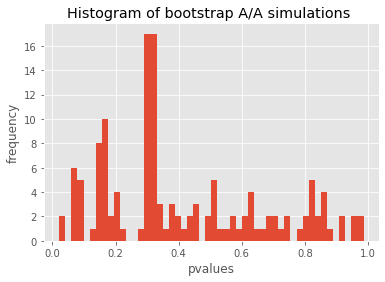

0.013333333333333334


In [115]:
n_s = 50
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_control_1.query('uid != 892333905').revenue.sample(n_s, replace = False)
    s2 = cr_control_2.revenue.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

**По скольку FPR < alpha(0.05), можно сделать вывод, что средние в группах стат.значимо не различаются.**

### ARPU

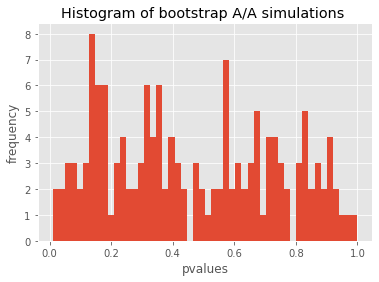

0.02666666666666667


In [116]:
n_s = 50
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = user_control_1_new.query('uid != 892333905').revenue.sample(n_s, replace = False)
    s2 = user_control_2_new.revenue.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

**По скольку FPR < alpha(0.05), можно сделать вывод, что средние в группах стат.значимо не различаются.**

### ARPPU по подписке Premium_no_trial

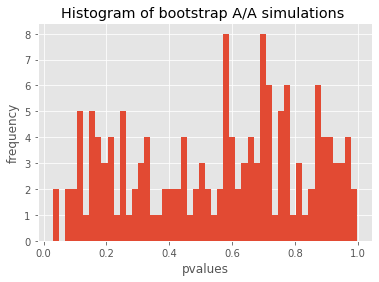

0.013333333333333334


In [117]:
n_s = 50
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = cr_control_1.query('revenue > 0 & uid != 892333905').revenue.sample(n_s, replace = False)
    s2 = cr_control_2.query('revenue > 0').revenue.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

**По скольку FPR < alpha(0.05), можно сделать вывод, что средние в группах стат.значимо не различаются.**

### ARPPU

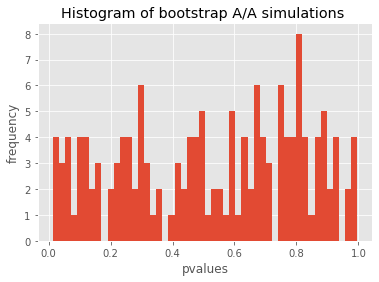

0.04666666666666667


In [118]:
n_s = 50
simulations = 150

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = user_control_1_new.query('revenue > 0 & uid != 892333905').revenue.sample(n_s, replace = False)
    s2 = user_control_2_new.query('revenue > 0').revenue.sample(n_s, replace = False)
    booted_data = get_bootstrap(s1, s2)
    res.append(booted_data["p_value"]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(sum(np.array(res) < 0.05) / simulations);

**По скольку FPR < alpha(0.05), можно сделать вывод, что средние в группах стат.значимо не различаются.**

#  Итог проверки A/A теста.

**Стат.значимых различий в исследуемых метриках между группами A1 и A2 обнаружено не было, можно переходить к А/B тестированию.**

#  Проверка А/B тестов

Для проведения A/B тестов CR будет использован метод хи-квадрата, для проведения A/B тестов ARPU и ARPPU будет использован Bootstrap.

### CR в покупку no_premium_trial

In [119]:
cr_full = pd.concat([cr_test[{'premium_no_trial', 'group'}],  
                     cr_control_1[{'premium_no_trial', 'group'}],  
                     cr_control_2[{'premium_no_trial', 'group'}]])
cr_full.premium_no_trial = cr_full.premium_no_trial.astype('int')

In [120]:
cr_full.groupby('group').agg({'premium_no_trial':'mean'})

,premium_no_trial
group,
control_1,0.022922
control_2,0.023832
test,0.015453


CR в контрольных группах выше, нежели в тестовой. Скорее всего это связанно с тем, что стоймость премиум подписки возросла. Проверим данные на стат.значимость.

H0 - группы не имеют стат.значимых различий.  
H1 - группы имеют стат.значимые различия.

In [121]:
scipy.stats.chi2_contingency(pd.crosstab(cr_full.query('group != "control_1"').group,  
                                         cr_full.query('group != "control_1"').premium_no_trial))

(7.332404192091014,
 0.006772240942126056,
 1,
 array([[4154.82383359,   83.17616641],
        [4187.17616641,   83.82383359]]))

In [122]:
scipy.stats.chi2_contingency(pd.crosstab(cr_full.query('group != "control_2"').group,  
                                         cr_full.query('group != "control_2"').premium_no_trial))

(5.9684138646181495,
 0.014564375509795792,
 1,
 array([[4236.03899884,   82.96100116],
        [4188.96100116,   82.03899884]]))

**Значения Pvalue в обоих случаях < 0.05, что означает, что в группах есть стат.значимые различия.**

### ARPU по подписке Premium_no_trial

In [123]:
print('Средний чек в тестовой группе B:', cr_test.revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', cr_control_1.query('uid != 892333905').revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', cr_control_2.revenue.mean().round(2))

Средний чек в тестовой группе B: 176.48
Средний чек в контрольной группе A1: 157.24
Средний чек в контрольной группе A1: 168.68


На первый взгляд разница есть, но является ли она стат значимой? Проведем тесты.

H0 - группы не имеют стат.значимых различий.  
H1 - группы имеют стат.значимые различия.

In [124]:
booted_data1 = get_bootstrap(cr_test.revenue,  
                            cr_control_1.query('uid != 892333905').revenue)
booted_data2 = get_bootstrap(cr_test.revenue,  
                            cr_control_2.revenue)
print('Сравнение А1/B:', booted_data1['p_value'])
print('Сравнение А2/B:', booted_data2['p_value'])

Сравнение А1/B: 0.6834888863045125
Сравнение А2/B: 0.8662034460407967


**В обоих тестах групп Pvalue > 0.05, следовательно стат.значимых различий обнаружено не было.**

### ARPU

In [125]:
print('Средний чек в тестовой группе B:', user_test_new.revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', user_control_1_new.query('uid != 892333905').revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', user_control_2_new.revenue.mean().round(2))

Средний чек в тестовой группе B: 543.92
Средний чек в контрольной группе A1: 484.23
Средний чек в контрольной группе A1: 444.33


На первый взгляд разница есть, но является ли она стат значимой? Проведем тесты.

H0 - группы не имеют стат.значимых различий.  
H1 - группы имеют стат.значимые различия.

In [126]:
booted_data1 = get_bootstrap(user_test_new.revenue,  
                            user_control_1_new.query('uid != 892333905').revenue)
booted_data2 = get_bootstrap(user_test_new.revenue,  
                            user_control_2_new.revenue)
print('Сравнение А1/B:', booted_data1['p_value'])
print('Сравнение А2/B:', booted_data2['p_value'])

Сравнение А1/B: 0.455910752629047
Сравнение А2/B: 0.19336011428809508


**В обоих тестах групп Pvalue > 0.05, следовательно стат.значимых различий обнаружено не было.**

 ### ARPPU по подписке Premium_no_trial

In [127]:
print('Средний чек в тестовой группе B:', cr_test.query('revenue > 0')  
      .revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', cr_control_1.query('revenue > 0 & uid != 892333905')  
      .revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', cr_control_2.query('revenue > 0')  
      .revenue.mean().round(2))

Средний чек в тестовой группе B: 11420.5
Средний чек в контрольной группе A1: 6928.07
Средний чек в контрольной группе A1: 7078.05


На первый взгляд разница есть, причем довольно большая. Проведем тесты.

H0 - группы не имеют стат.значимых различий.  
H1 - группы имеют стат.значимые различия.

In [128]:
booted_data1 = get_bootstrap(cr_test.query('revenue > 0').revenue,  
                                              cr_control_1.query('revenue > 0 & uid != 892333905').revenue)
booted_data2 = get_bootstrap(cr_test.query('revenue > 0').revenue,  
                                              cr_control_2.query('revenue > 0').revenue)
print('Сравнение А1/B:', booted_data1['p_value'])
print('Сравнение А2/B:', booted_data2['p_value'])

Сравнение А1/B: 0.022002024410823124
Сравнение А2/B: 0.03463181831606747


**В обоих тестах групп Pvalue < 0.05, следовательно результат стат.значим.**

### ARPPU

In [129]:
print('Средний чек в тестовой группе B:', user_test_new.query('revenue > 0')  
      .revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', user_control_1_new.query('revenue > 0 & uid != 892333905')  
      .revenue.mean().round(2))
print('Средний чек в контрольной группе A1:', user_control_2_new.query('revenue > 0')  
      .revenue.mean().round(2))

Средний чек в тестовой группе B: 16021.11
Средний чек в контрольной группе A1: 10947.09
Средний чек в контрольной группе A1: 10178.72


На первый взгляд разница есть, причем довольно большая. Проведем тесты.

H0 - группы не имеют стат.значимых различий.  
H1 - группы имеют стат.значимые различия.

In [130]:
booted_data1 = get_bootstrap(user_test_new.query('revenue > 0').revenue,  
                                              user_control_1_new.query('revenue > 0 & uid != 892333905').revenue)
booted_data2 = get_bootstrap(user_test_new.query('revenue > 0').revenue,  
                                              user_control_2_new.query('revenue > 0').revenue)
print('Сравнение А1/B:', booted_data1['p_value'])
print('Сравнение А2/B:', booted_data2['p_value'])

Сравнение А1/B: 0.0007077379817899262
Сравнение А2/B: 0.00013882362528310342


**В обоих тестах групп Pvalue < 0.05, следовательно результат стат.значим.**

### ARPU по подписке Premium_no_trial в разных возростных группах

In [131]:
age_group = ['0-18', '19-35', '36-60', '60+']

In [132]:
a_list = []
b_list = []
for el in age_group:
    compare_bs = get_bootstrap(cr_test.query('age_group == @el').revenue, # числовые значения первой выборки
                        cr_control_2.query('uid != 892333905 & age_group == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a1b_age = pd.DataFrame({'age_group': a_list, 'p_value': b_list})
del a_list, b_list

In [133]:
a1b_age

,age_group,p_value
0,0-18,0.520243
1,19-35,0.542248
2,36-60,0.229129
3,60+,0.939797


In [134]:
a_list = []
b_list = []
for el in age_group:
    compare_bs = get_bootstrap(cr_test.query('age_group == @el').revenue, # числовые значения первой выборки
                        cr_control_1.query('uid != 892333905 & age_group == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a2b_age = pd.DataFrame({'age_group': a_list, 'p_value': b_list})
del a_list, b_list

In [135]:
a2b_age

,age_group,p_value
0,0-18,0.883921
1,19-35,0.497298
2,36-60,0.254613
3,60+,0.706780


**В обоих случаях Pvalue > 0.05, стат.значимых различий обнаружено не было.**

### ARPU в разных возростных группах

In [136]:
a_list = []
b_list = []
for el in age_group:
    compare_bs = get_bootstrap(user_test_new.query('age_group == @el').revenue, # числовые значения первой выборки
                        user_control_1_new.query('uid != 892333905 & age_group == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a1b_age_full = pd.DataFrame({'age_group': a_list, 'p_value': b_list})
del a_list, b_list

In [137]:
a1b_age_full

,age_group,p_value
0,0-18,0.216928
1,19-35,0.743945
2,36-60,0.346646
3,60+,0.737399


In [138]:
a_list = []
b_list = []
for el in age_group:
    compare_bs = get_bootstrap(user_test_new.query('age_group == @el').revenue, # числовые значения первой выборки
                        user_control_2_new.query('uid != 892333905 & age_group == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a2b_age_full = pd.DataFrame({'age_group': a_list, 'p_value': b_list})
del a_list, b_list

In [139]:
a2b_age_full

,age_group,p_value
0,0-18,0.444877
1,19-35,0.090312
2,36-60,0.812754
3,60+,0.456645


**В обоих случаях Pvalue > 0.05, стат.значимых различий обнаружено не было.**

### ARPU по подписке Premium_no_trial по странам.

In [155]:
a_list = []
b_list = []
for el in country:
    compare_bs = get_bootstrap(cr_test.query('country_x == @el').revenue, # числовые значения первой выборки
                        cr_control_1.query('uid != 892333905 & country_x == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a1b_country = pd.DataFrame({'country': a_list, 'p_value': b_list})
del a_list, b_list

In [156]:
a1b_country

,country,p_value
0,Argentina,0.577643
1,Australia,0.436571
2,Belgium,0.365646
3,Canada,0.931240
4,Chile,0.600439
5,Colombia,NaN
6,Costa Rica,NaN
7,Dominican Republic,NaN
8,France,0.088000
9,Germany,0.394159


In [142]:
a_list = []
b_list = []
for el in country:
    compare_bs = get_bootstrap(cr_test.query('country_x == @el').revenue, # числовые значения первой выборки
                        cr_control_2.query('country_x == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a2b_country = pd.DataFrame({'country': a_list, 'p_value': b_list})
del a_list, b_list

In [143]:
a2b_country

,country,p_value
0,Argentina,0.936943
1,Australia,0.646369
2,Belgium,0.290444
3,Canada,0.242208
4,Chile,0.896462
5,Colombia,NaN
6,Costa Rica,NaN
7,Dominican Republic,NaN
8,France,0.443444
9,Germany,0.366110


Наблюдаем стат.значимое различие в Португалии между тестовой группой B и контрольной A2.  
Проверим данные на репрезентативность, а так же посмотрим, в какую сторону идет изменение.

In [144]:
print('Количество пользователей из Португалии в тестовой группе B:', cr_test.query('country_x == "Portugal"').uid.nunique())
print('Количество пользователей из Португалии в контрольной группе A2:', cr_control_2
                                                                         .query('country_x == "Portugal"').uid.nunique())

Количество пользователей из Португалии в тестовой группе B: 91
Количество пользователей из Португалии в контрольной группе A2: 100


In [145]:
print('Общая выручка пользователей из Португалии в тестовой группе B:', cr_test.query('country_x == "Portugal"').revenue.sum())
print('Общая выручка пользователей из Португалии в контрольной группе A2:', cr_control_2
                                                                           .query('country_x == "Portugal"').revenue.sum())

Общая выручка пользователей из Португалии в тестовой группе B: 0.0
Общая выручка пользователей из Португалии в контрольной группе A2: 24336.0


**Наблюдаем негативное влияние для пользователей из Португалии. Для остальных стран стат.значимых различий обнаружено не было.**

### ARPU  по странам.

In [146]:
a_list = []
b_list = []
for el in country:
    compare_bs = get_bootstrap(user_test_new.query('country == @el').revenue, # числовые значения первой выборки
                        user_control_1_new.query('uid != 892333905 & country == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a1b_country_full = pd.DataFrame({'country': a_list, 'p_value': b_list})
del a_list, b_list

In [147]:
a1b_country_full

,country,p_value
0,Argentina,0.684338
1,Australia,0.586343
2,Belgium,0.473177
3,Canada,0.715039
4,Chile,0.672720
5,Colombia,NaN
6,Costa Rica,NaN
7,Dominican Republic,NaN
8,France,0.268425
9,Germany,0.136613


In [148]:
a_list = []
b_list = []
for el in country:
    compare_bs = get_bootstrap(user_test_new.query('country == @el').revenue, # числовые значения первой выборки
                        user_control_2_new.query('country == @el').revenue, # числовые значения второй выборки
                        boot_it = 100, # количество бутстрэп-подвыборок
                        statistic = np.mean, # интересующая нас статистика
                        bootstrap_conf_level = 0.95, # уровень значимости
                        )
    a_list.append(el)
    b_list.append(compare_bs['p_value'])
a2b_country_full = pd.DataFrame({'country': a_list, 'p_value': b_list})
del a_list, b_list

In [149]:
a2b_country_full

,country,p_value
0,Argentina,0.577181
1,Australia,0.508588
2,Belgium,0.374784
3,Canada,0.440537
4,Chile,0.539150
5,Colombia,NaN
6,Costa Rica,NaN
7,Dominican Republic,NaN
8,France,0.119792
9,Germany,0.813962


Наблюдаем стат.значимое различие в Португалии между тестовой группой B и контрольной A2.  
Проверим данные на репрезентативность, а так же посмотрим, в какую сторону идет изменение.

In [150]:
print('Количество пользователей из Португалии в тестовой группе B:', user_test_new
                                                                     .query('country == "Portugal"').uid.nunique())
print('Количество пользователей из Португалии в контрольной группе A2:', user_control_2_new
                                                                         .query('country == "Portugal"').uid.nunique())

Количество пользователей из Португалии в тестовой группе B: 91
Количество пользователей из Португалии в контрольной группе A2: 100


In [151]:
print('Общая выручка пользователей из Португалии в тестовой группе B:', user_test_new
                                                                        .query('country == "Portugal"').revenue.sum())
print('Общая выручка пользователей из Португалии в контрольной группе A2:', user_control_2_new
                                                                           .query('country == "Portugal"').revenue.sum())

Общая выручка пользователей из Португалии в тестовой группе B: 0.0
Общая выручка пользователей из Португалии в контрольной группе A2: 53807.0


**Наблюдаем негативное влияние для пользователей из Португалии. Для остальных стран стат.значимых различий обнаружено не было.**

## Вывод:
**Для ARPU в результате A/B теста положительного эффекта обнаружено не было как для подписки premium_no_trial, так и в целом.  
Для ARPPU в результате A/B теста положительный эффект наблюдается как для подписки premium_no_trial, так и в целом.  
В разрезе по странам положительного эффекта для ARPU обнаружено не было как для подписки premium_no_trial, так и в целом.  
В разрезе по взрастам положительного эффекта для ARPU обнаружено не было как для подписки premium_no_trial, так и в целом.  
В итоге хоть ARPPU вырос, из-за увеличения цен CR снизился и ARPU не получил стат.значимых изменений.**    

**После проведения тестов статистически было даказано, что ARPU не возрос. Хоть ARPPU и стал выше, больше денег это приносить не стало, следовательно расскатывать фичу не имеет смысла.**